In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DeepLearning/detection_fruit_projet/

Mounted at /content/drive
/content/drive/MyDrive/DeepLearning/detection_fruit_projet


In [ ]:
%ls

sample_data/


#imports

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from xml.etree import ElementTree as et
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 506.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.6 MB/s eta 

In [ ]:
train_data = '/content/drive/MyDrive/DeepLearning/detection_fruit_projet/train_zip/train'
labels = ['background', 'orange', 'apple', 'banana']
label2targets = {l: t for t, l in enumerate(labels)}
targets2label = {t: l for l, t in label2targets.items()}
num_classes = len(targets2label)

In [ ]:
#dans le but de convertir une image en un tenseur pytorch
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0 ,1)
    return img.to(device).float()

In [ ]:
class FruitsDataset(Dataset):
    def __init__(self, root=train_data, transforms=None):
        self.root = root
        self.transforms = transforms
        self.img_paths = sorted(Glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(Glob(self.root + '/*.xml'))

    def __len__(self):
        return len(self.img_paths)

    #read an image and associated labels
    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.img_paths[idx]
        xlm_path = self.xlm_paths[idx]
        img = Image.open(img_path).convert('RGB')
        W, H = img.size
        img = np.array(img.resize((w, h),
                       resample=Image.Resampling.BILINEAR))/255.
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        boxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(label)
            XMin = float(obj.find('bndbox').find('xmin').text)
            YMin = float(obj.find('bndbox').find('ymin').text)
            XMax = float(obj.find('bndbox').find('xmax').text)
            YMax = float(obj.find('bndbox').find('ymax').text)
            bbox = [XMin / W, YMin / H, XMax / W, YMax / H]
            bbox = (bbox * np.array([w, h, w, h])).astype(np.int16).tolist()
            boxes.append(bbox)
        target = {}
        target['labels'] = torch.tensor([label2targets[label] for label in labels]).long()
        target['boxes'] = torch.tensor(boxes).float()
        img = preprocess_img(img)
        return img, target

    def collate_fn(self, batch):
      return tuple(zip(*batch))

In [ ]:
validation_data = '/content/drive/MyDrive/DeepLearning/detection_fruit_projet/test_zip/test'

In [ ]:
tr_ds = FruitsDataset()
tr_dl = DataLoader(tr_ds, batch_size=4, shuffle=True, collate_fn=tr_ds.collate_fn)

val_ds = FruitsDataset(root=validation_data)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True, collate_fn=val_ds.collate_fn)

img, target = tr_ds[10]

#let's create our model now

In [ ]:
def get_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #print(in_features)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

#test the model

In [ ]:
# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 134MB/s]


{'loss_classifier': tensor(1.6904, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.4512, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0058, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0083, device='cuda:0', grad_fn=<DivBackward0>)}

In [ ]:
def train_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optim.step()
    return loss, losses

In [ ]:
@torch.no_grad()
def validate_batch(batch, model, optim):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optim.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

EPOCH: 0.017  trn_loss: 2.078  trn_loc_loss: 1.477  trn_regr_loss: 0.584  trn_loss_objectness: 0.009  trn_loss_rpn_box_reg: 0.008  (1.37s - 410.82s remaining)
EPOCH: 0.033  trn_loss: 0.743  trn_loc_loss: 0.485  trn_regr_loss: 0.251  trn_loss_objectness: 0.000  trn_loss_rpn_box_reg: 0.007  (2.18s - 324.23s remaining)
EPOCH: 0.050  trn_loss: 0.717  trn_loc_loss: 0.311  trn_regr_loss: 0.379  trn_loss_objectness: 0.019  trn_loss_rpn_box_reg: 0.008  (2.91s - 288.42s remaining)
EPOCH: 0.067  trn_loss: 0.614  trn_loc_loss: 0.327  trn_regr_loss: 0.273  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.006  (3.69s - 272.85s remaining)
EPOCH: 0.083  trn_loss: 0.719  trn_loc_loss: 0.370  trn_regr_loss: 0.325  trn_loss_objectness: 0.008  trn_loss_rpn_box_reg: 0.016  (4.44s - 261.91s remaining)
EPOCH: 0.100  trn_loss: 1.122  trn_loc_loss: 0.655  trn_regr_loss: 0.457  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.004  (5.18s - 253.89s remaining)
EPOCH: 0.117  trn_loss: 0.589  trn_loc_loss: 0

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


EPOCH: 0.183  trn_loss: 0.663  trn_loc_loss: 0.250  trn_regr_loss: 0.393  trn_loss_objectness: 0.003  trn_loss_rpn_box_reg: 0.016  (9.15s - 240.46s remaining)
EPOCH: 0.200  trn_loss: 0.495  trn_loc_loss: 0.184  trn_regr_loss: 0.292  trn_loss_objectness: 0.012  trn_loss_rpn_box_reg: 0.007  (9.93s - 238.30s remaining)
EPOCH: 0.217  trn_loss: 0.389  trn_loc_loss: 0.145  trn_regr_loss: 0.231  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.009  (10.95s - 241.76s remaining)
EPOCH: 0.233  trn_loss: 0.542  trn_loc_loss: 0.234  trn_regr_loss: 0.293  trn_loss_objectness: 0.005  trn_loss_rpn_box_reg: 0.010  (11.79s - 240.88s remaining)
EPOCH: 0.250  trn_loss: 0.623  trn_loc_loss: 0.208  trn_regr_loss: 0.390  trn_loss_objectness: 0.013  trn_loss_rpn_box_reg: 0.013  (12.81s - 243.33s remaining)
EPOCH: 0.267  trn_loss: 0.402  trn_loc_loss: 0.155  trn_regr_loss: 0.237  trn_loss_objectness: 0.006  trn_loss_rpn_box_reg: 0.005  (13.57s - 240.89s remaining)
EPOCH: 0.283  trn_loss: 0.275  trn_loc_los

100%|██████████| 106/106 [00:00<00:00, 1341.78it/s]


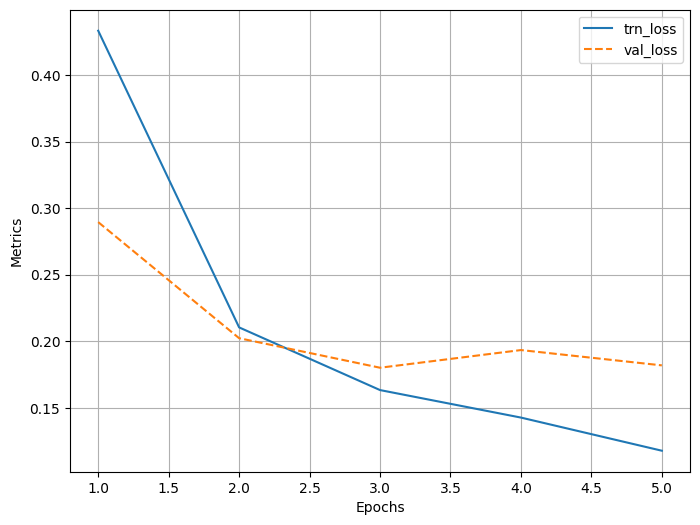

In [ ]:
model = get_model().to(device)
optim = torch.optim.SGD(model.parameters(), lr=0.005,
                       weight_decay=5e-4, momentum=0.9)

n_epochs = 5
log = Report(n_epochs)
for e in range(n_epochs):
    for i, batch in enumerate(tr_dl):
        N = len(tr_dl)
        loss, losses = train_batch(batch, model, optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item())
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses = validate_batch(batch, model.float(), optim)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in
                                                                  ['loss_classifier', 'loss_box_reg',
                                                                   'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item())
    log.report_avgs(e+1)
log.plot_epochs(['trn_loss', 'val_loss'])

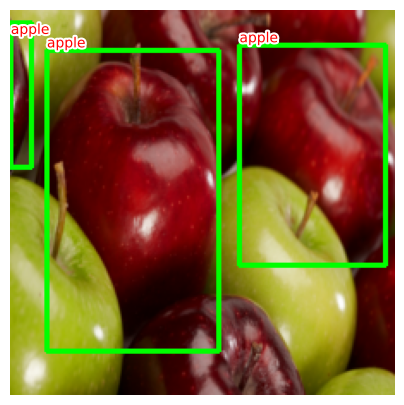

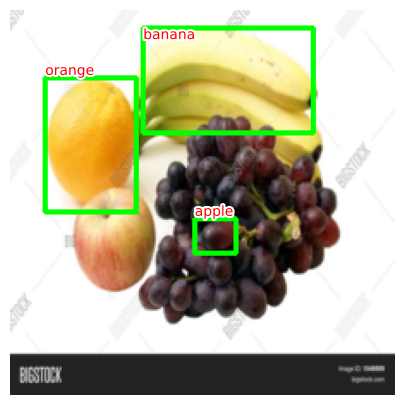

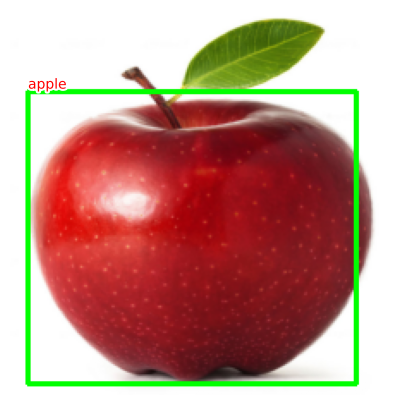

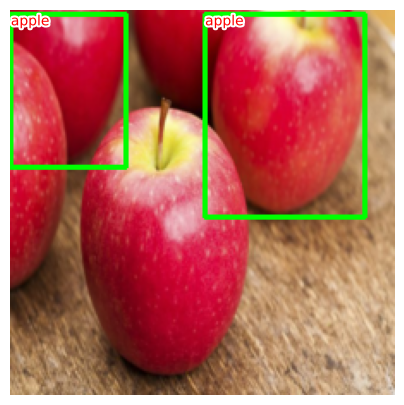

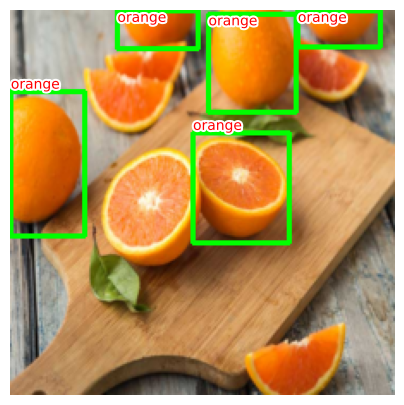

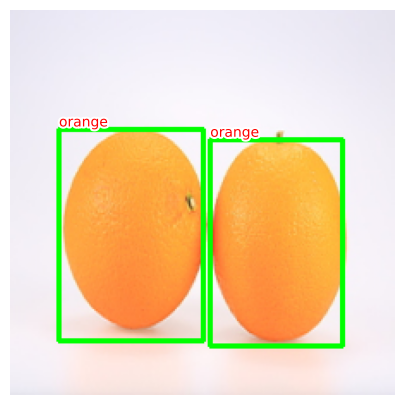

In [ ]:
from torchvision.ops import nms

def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([targets2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

model.eval()
for i, (images, targets) in enumerate(val_dl):
    if i == 3: break
    images = [im for im in images]
    outputs = model(images)
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        show(images[i].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5, text_sz=10)

#enregistrer le modèle

In [ ]:
# À la fin de ton code d'entraînement
torch.save(model.state_dict(), 'model_fruit_detection.pth')

#upload image and detection

In [21]:
import torch
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
from PIL import Image as PILImage
from google.colab import files
from IPython.display import display, Image

In [ ]:
#load the detection model# Charger le modèle
model = get_model().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearning/detection_fruit_projet/model_fruit_detection.pth'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [40]:
from torchvision.transforms import ToTensor, Resize

def preprocess_img(img):
    # Redimensionner l'image à une taille fixe (par exemple, 224x224)
    img = Resize((224, 224))(img)

    # Convertir en tensor
    img = ToTensor()(img).permute(1, 2, 0)  # Permutation pour ajuster les dimensions
    return img.to(device).float()


In [36]:
def preprocess_image(image_path):
    img = PILImage.open(image_path).convert('RGB')
    img_tensor = preprocess_img(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)  # Ajouter une dimension pour batch
    return img_tensor, img

In [43]:
# Détection d'objets sur l'image
def detect_objects(image_path):
    print("Taille de l'image avant le prétraitement:", image_path.size)
    img_tensor, original_img = preprocess_image(image_path)

    with torch.no_grad():
        prediction = model(img_tensor)

    return prediction, original_img

In [44]:
def draw_boxes(image, boxes, labels):
    draw = ImageDraw.Draw(image)
    for box, label in zip(boxes, labels):
        draw.rectangle(box, outline='red', width=2)
        draw.text((box[0], box[1]), label, fill='red')

In [45]:
# Charger une image et effectuer la détection
image_path = '/content/drive/MyDrive/DeepLearning/detection_fruit_projet/apple_79.jpg'
prediction, original_img = detect_objects(image_path)

# Récupérer les boîtes englobantes et les labels prédits
boxes = prediction[0]['boxes'].cpu().numpy()
labels = [str(int(label)) for label in prediction[0]['labels'].cpu().numpy()]

# Dessiner les boîtes sur l'image originale
draw_boxes(original_img, boxes, labels)
original_img.show()

AttributeError: ignored

In [29]:
def handle_upload():
    # Récupérez le premier fichier téléversé
    img_path = list(files.upload().keys())[0]

    # Effectuer la détection d'objets
    prediction, original_img = detect_objects(img_path)

    # Récupérer les boîtes englobantes et les labels prédits
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = [str(int(label)) for label in prediction[0]['labels'].cpu().numpy()]

    # Dessiner les boîtes sur l'image originale
    draw_boxes(original_img, boxes, labels)

    # Afficher l'image avec les boîtes dessinées
    display(original_img)

In [30]:
handle_upload()

Saving apple_87.jpg to apple_87.jpg


AttributeError: ignored